In [357]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, make_scorer, root_mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
import joblib
from sklearn.linear_model import ElasticNet,Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [329]:
def density_plot(data: pd):
    data.plot(kind='density', subplots=True, layout=(3,3),sharex=False, figsize = (20,20))
    plt.show()

def box_plot_multi(x, y, data):
    x_columns = list(x.columns)  # Obtener los nombres de las columnas de x
    y = list(y.columns)
    fig, axes = plt.subplots(len(x_columns), 1, figsize=(8, len(x_columns) * 4))  # Crear subplots en una columna
    for i, col in enumerate(x_columns):
        sns.boxplot(x=y[0], y=col, data=data, ax=axes[i], hue=y[0],palette='Set2' )  # Crear el gráfico de caja en cada subplot
    plt.tight_layout()
    plt.show()

def box_plot(x, data: pd.DataFrame):
    n_columns = 4  # Número de columnas por fila
    total = len(x.columns)  # Número total de columnas en el DataFrame
    
    # Calcular el número de filas necesario
    n_rows = (total + n_columns - 1) // n_columns
    
    # Aumentar el tamaño de la figura para que los gráficos no estén tan apretados
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(10, 5))
    
    # Asegurarnos de aplanar la cuadrícula para iterar fácilmente sobre ella
    axes = axes.flatten()
    
    for i, col in enumerate(x.columns):
        sns.boxplot(data=x, y=col, ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}', fontsize=12)
    
    # Eliminar los subplots vacíos si hay menos gráficos que espacios en la cuadrícula
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Ajustar el espacio entre los subplots
    plt.tight_layout()
    plt.show()


### PROBLEMA DE REGRESIÓN

In [330]:
df = pd.read_csv('CarPrice_Assignment.csv')

In [331]:
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [332]:
# Eliminamos las columnas de car_ID y CarName que no nos sirven para la clasificación
import copy
df_copy = copy.deepcopy(df)
df_copy = df_copy.drop(columns=['car_ID', 'CarName'], axis=1)

In [333]:
df_copy.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [334]:
df_copy.dtypes

symboling             int64
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

In [335]:
df_copy.describe()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [336]:
missing_values = df_copy.isnull().sum()
print(missing_values)

symboling           0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64


No hay valores faltantes en ninguna de las categorias

In [337]:
# VARIABLES CATEGORICAS 
cat_var = (df_copy.dtypes == 'object')

In [338]:
object_type = list(cat_var[cat_var].index)

In [339]:
#VARIABLES NUMERICAS 
num_var = (df_copy.dtypes != 'object')

In [340]:
num_type = list(num_var[num_var].index)

In [341]:
object_type

['fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem']

In [342]:
num_type

['symboling',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'curbweight',
 'enginesize',
 'boreratio',
 'stroke',
 'compressionratio',
 'horsepower',
 'peakrpm',
 'citympg',
 'highwaympg',
 'price']

In [343]:
#Función para plotear variables numericas de un dataframe 
def displot_numeric(x: list, df: pd.DataFrame):
    n_columns = 4  # Número de columnas por fila
    total = len(x)  # Número total de columnas en el DataFrame
    # Calcular el número de filas necesario
    n_rows = (total + n_columns - 1) // n_columns
    # Aumentar el tamaño de la figura para que los gráficos no estén tan apretados
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 10))
    
    # Asegurarnos de aplanar la cuadrícula para iterar fácilmente sobre ella
    axes = axes.flatten()
    
    # Graficar cada variable numérica
    for i, col in enumerate(x):
        sns.histplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(f'Displot of {col}')

    # Eliminar los subplots vacíos si hay menos gráficos que espacios en la cuadrícula
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Ajustar el espacio entre los subplots
    plt.tight_layout()
    plt.show()

In [344]:
#Función para plotear variables numericas de un dataframe 
def box_numeric(x: list, df: pd.DataFrame):
    n_columns = 4  # Número de columnas por fila
    total = len(x)  # Número total de columnas en el DataFrame
    # Calcular el número de filas necesario
    n_rows = (total + n_columns - 1) // n_columns
    # Aumentar el tamaño de la figura para que los gráficos no estén tan apretados
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 10))
    
    # Asegurarnos de aplanar la cuadrícula para iterar fácilmente sobre ella
    axes = axes.flatten()
    
    # Graficar cada variable numérica
    for i, col in enumerate(x):
        sns.boxplot(data=df, y=col, ax=axes[i])
        axes[i].set_title(f'Displot of {col}')

    # Eliminar los subplots vacíos si hay menos gráficos que espacios en la cuadrícula
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Ajustar el espacio entre los subplots
    plt.tight_layout()
    plt.show()

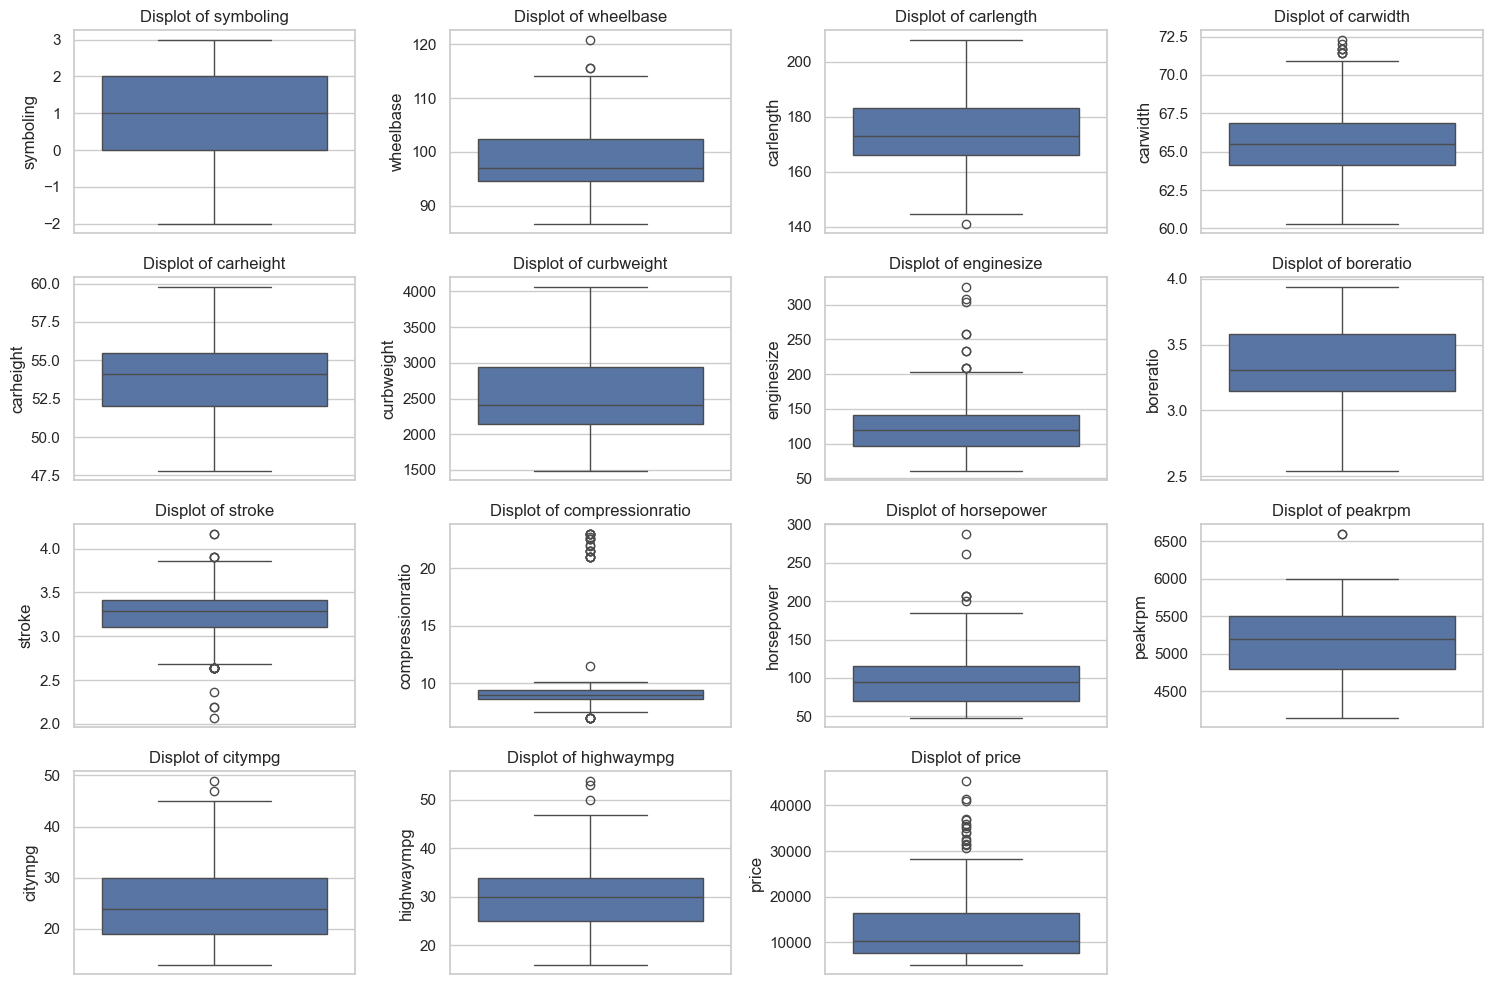

In [345]:
box_numeric(num_type, df_copy)

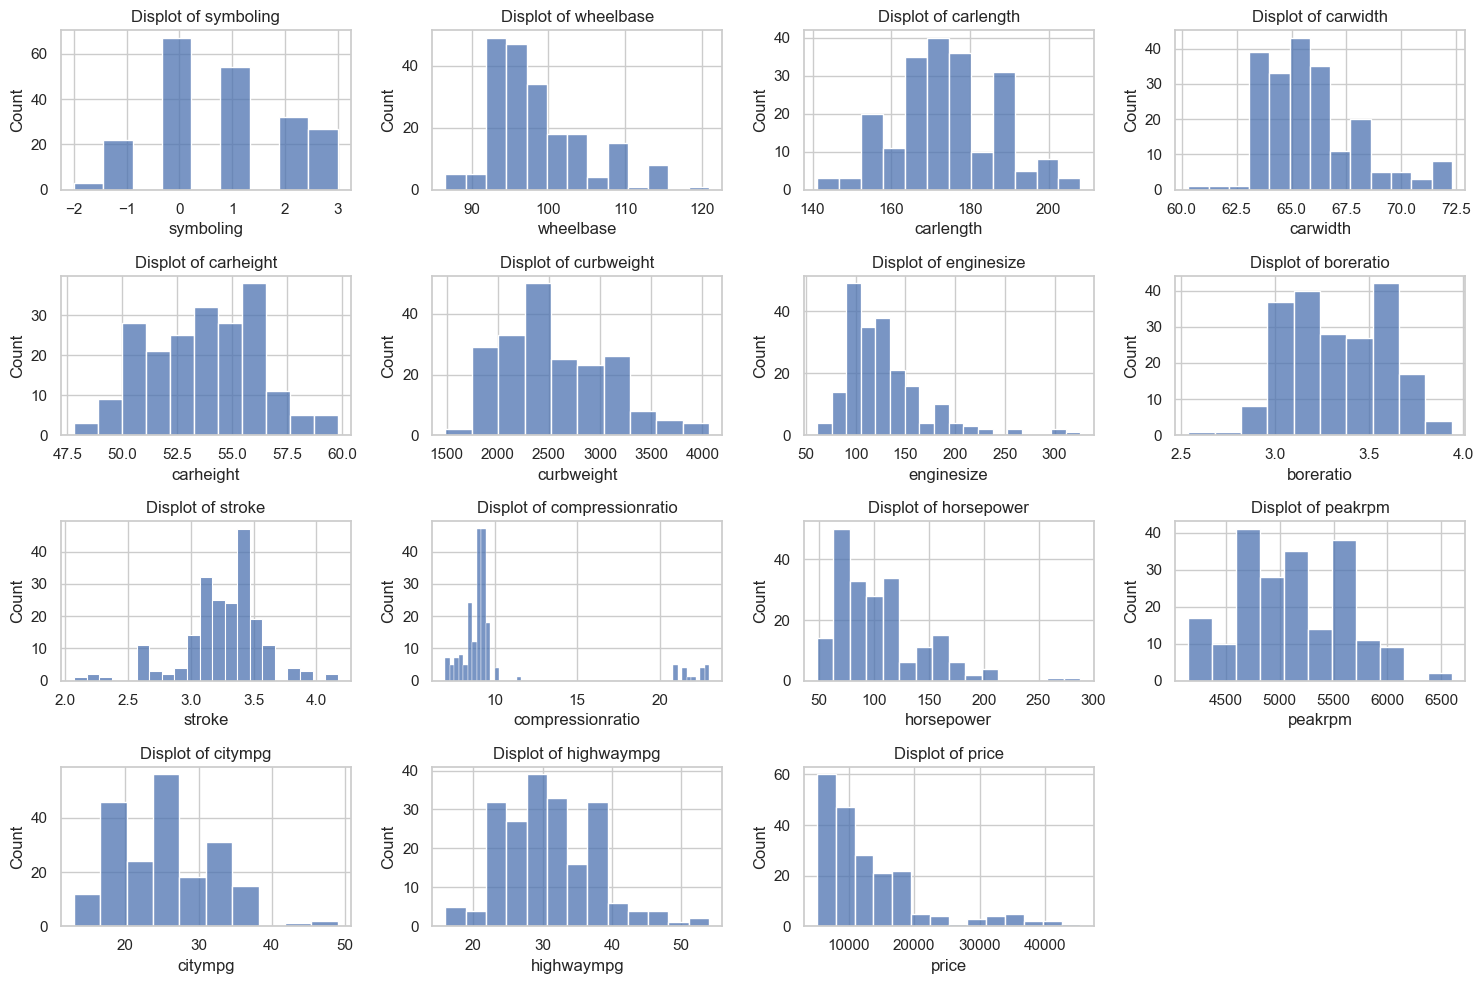

In [346]:
displot_numeric(num_type, df_copy)

In [347]:
y = df_copy.price
x_num = df_copy[num_type]
x_cat = df_copy[object_type]

In [348]:
def PlotCatVtarget(x: list, df: pd.DataFrame, target: str):
    n_columns = 4  # Número de columnas por fila
    total = len(x)  # Número total de variables categóricas
    # Calcular el número de filas necesario
    n_rows = (total + n_columns - 1) // n_columns
    # Aumentar el tamaño de la figura para que los gráficos no estén tan apretados
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 10))
    
    # Asegurarnos de aplanar la cuadrícula para iterar fácilmente sobre ella
    axes = axes.flatten()
    
    # Graficar cada variable categórica contra la variable objetivo
    for i, col in enumerate(x):
        sns.boxplot(data=df, x=col, y=target, ax=axes[i])
        axes[i].set_title(f'Boxplot of {col} vs {target}')
        axes[i].tick_params(axis='x', rotation=90)  
        
    # Eliminar los subplots vacíos si hay menos gráficos que espacios en la cuadrícula
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Ajustar el espacio entre los subplots
    plt.tight_layout()
    plt.show()


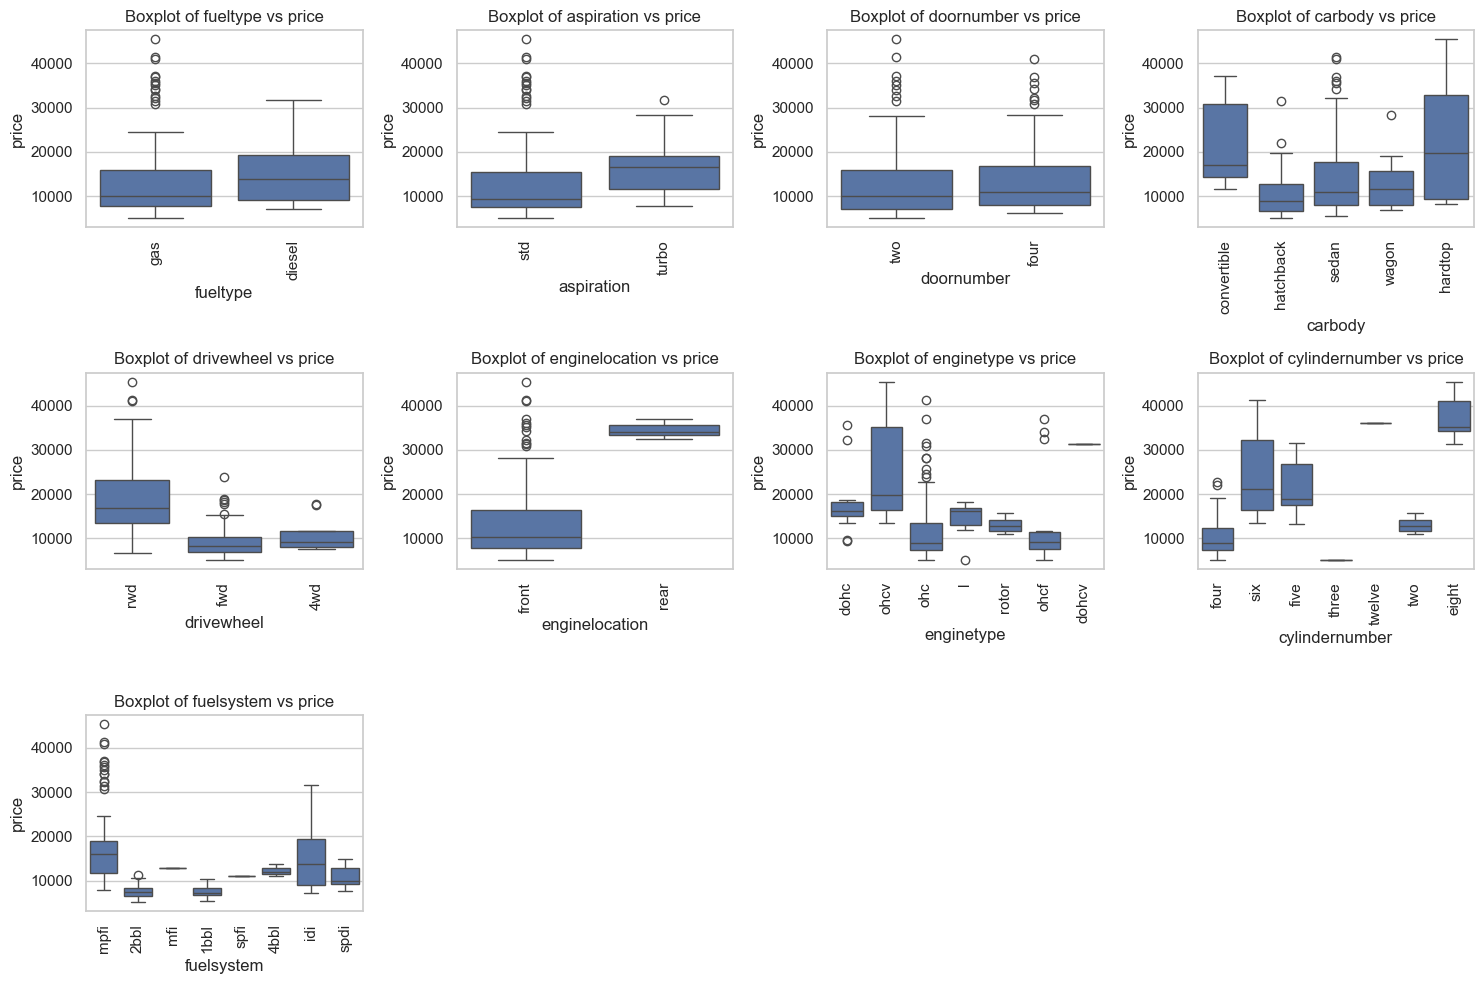

In [349]:
PlotCatVtarget(object_type, df_copy, target='price')

In [23]:
def PlotPairPlotNumTarget(x_num: list, df: pd.DataFrame, target: str):
    # Concatenar las variables numéricas con la variable target en un solo DataFrame
    # Asegurarse de que target esté incluido en x_num si quieres visualizarlo también
    if target not in x_num:
        x_num = x_num + [target]
    
    # Seleccionar solo las columnas numéricas para evitar errores
    data_numeric = df[x_num].select_dtypes(include=['float64', 'int64'])
    
    # Crear el pairplot usando seaborn
    sns.pairplot(data_numeric, diag_kind='kde')  # 'kde' para gráficos de densidad en la diagonal
    plt.show()

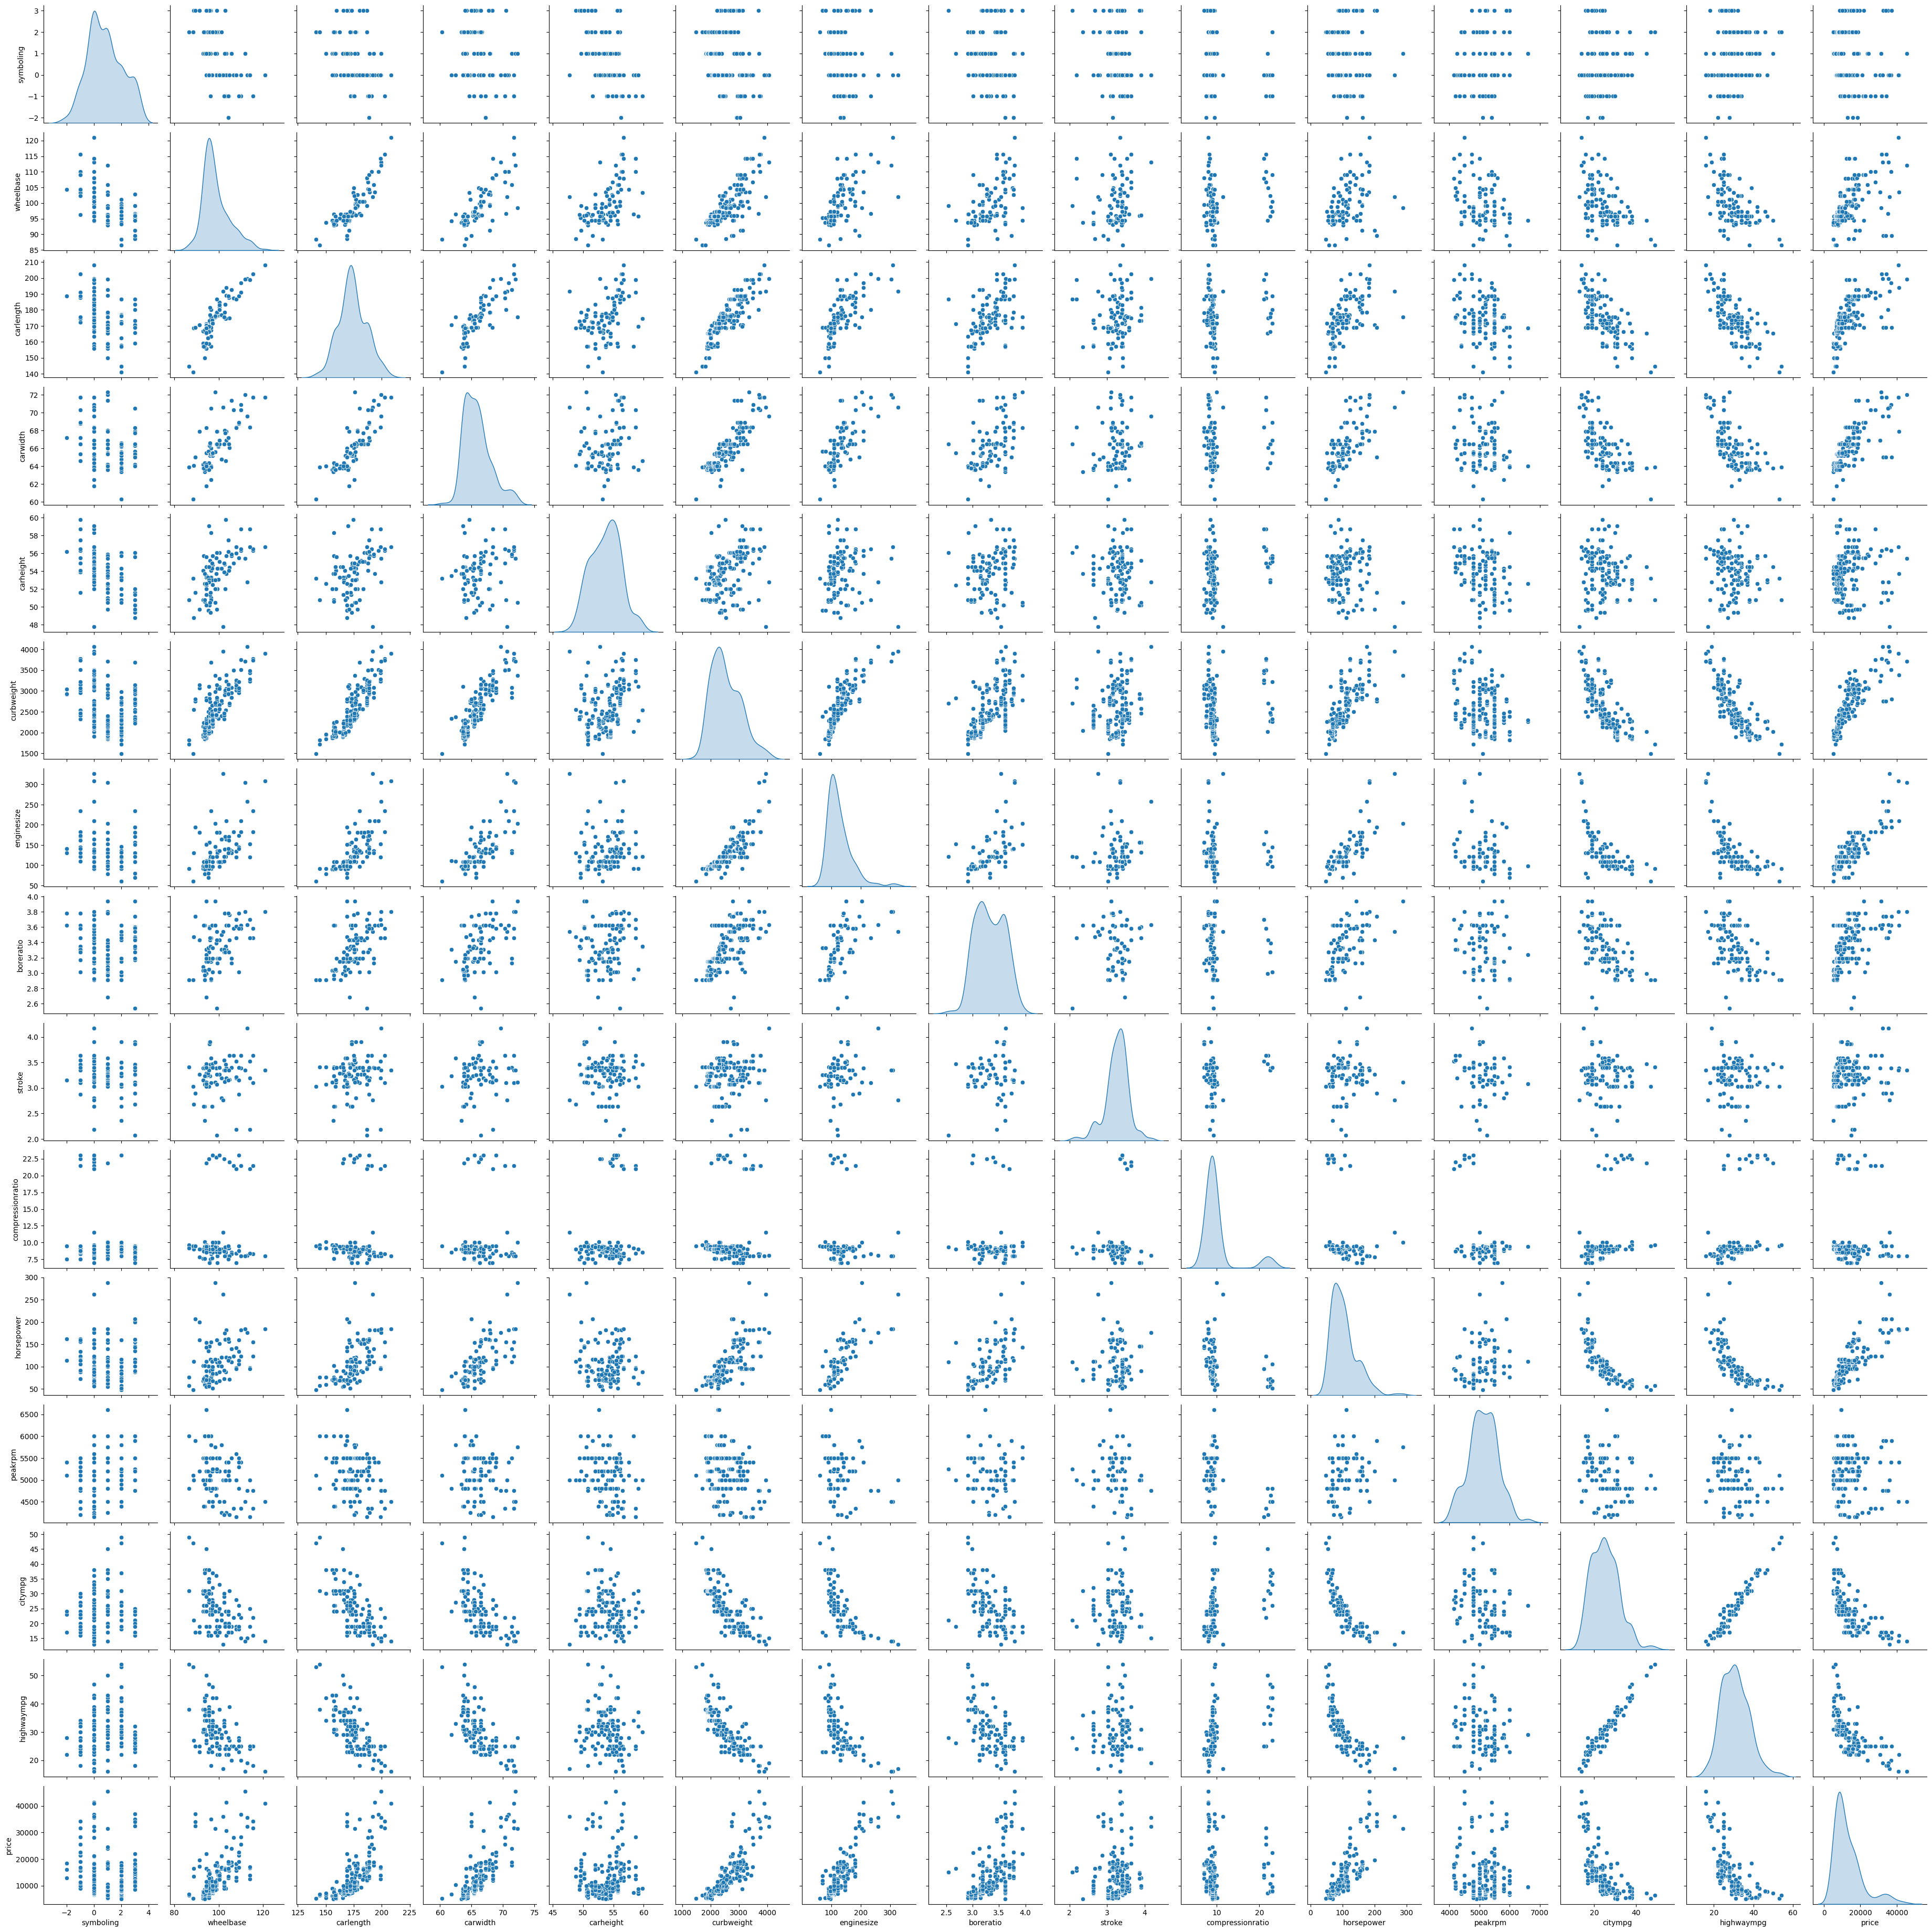

In [24]:
PlotPairPlotNumTarget(num_type, df_copy, target='price')

In [25]:
def corr_matriz(df):
    # Seleccionar solo las columnas numéricas del DataFrame
    df_numeric = df.select_dtypes(include=['float64', 'int64'])

    # Calcular la matriz de correlación
    correlation = df_numeric.corr()

    # Graficar la matriz de correlación
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='viridis')
    plt.title('Correlation Matrix')
    plt.show()

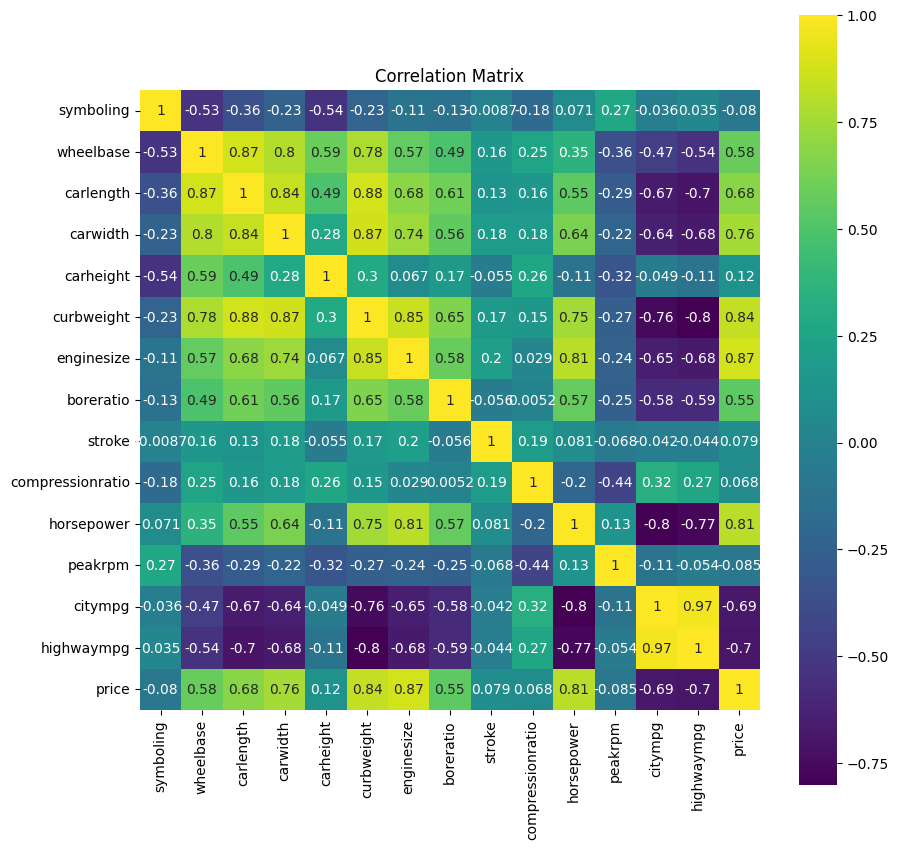

In [26]:
corr_matriz(df_copy)

Las caracteristicas de 'carwidth', 'curbweight', 'enginesize' y 'horsepower' son las que mejor se realción con la variable objetivo del precio.

## **Primer entrenamiento** 

## RANDOMFOREST tomando en cuenta solo las variables numericas

In [350]:
y = y
X = x_num.drop(columns=['price'])

In [351]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42)

In [352]:
print(f'Cantidad de datos para entrenamiento: {X_train.shape[0]}')
print(f'Cantidad de datos para validacion: {X_val.shape[0]}')

Cantidad de datos para entrenamiento: 164
Cantidad de datos para validacion: 41


In [353]:
model = RandomForestRegressor(n_estimators=200,  # Número de árboles en el bosque
                              max_depth=20,      # Profundidad máxima de los árboles
                              random_state=42,   # Semilla para reproducibilidad
                              n_jobs=-1)         # Utilizar todos los núcleos disponibles

In [354]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [355]:
y_hat = model.predict(X_val)

In [363]:
#Evaluamos el modelo 
error = root_mean_squared_error(y_val, y_hat)
print(f"El RME del modelo en validacion: {error:.4f}$")

El RME del modelo en validacion: 1778.5896$


In [367]:
y_pred_train = model.predict(X_train)
mse_train = root_mean_squared_error(y_train, y_pred_train)
print(f"RME en entrenamiento: {mse_train}")

RME en entrenamiento: 950.9981749964568


In [368]:
# Obtener las importancias
importances = model.feature_importances_

# Crear un DataFrame para organizar las importancias
feature_names = X.columns
importance_df = pd.DataFrame({
    'Característica': feature_names,
    'Importancia': importances
})

# Ordenar por importancia descendente
importance_df = importance_df.sort_values(by='Importancia', ascending=False)

print("Importancia de las Características:")
print(importance_df)

Importancia de las Características:
      Característica  Importancia
6         enginesize     0.586058
5         curbweight     0.272611
13        highwaympg     0.043309
10        horsepower     0.029273
3           carwidth     0.013676
2          carlength     0.010805
1          wheelbase     0.008214
11           peakrpm     0.007213
12           citympg     0.007105
8             stroke     0.005790
7          boreratio     0.005692
9   compressionratio     0.004833
4          carheight     0.004297
0          symboling     0.001122


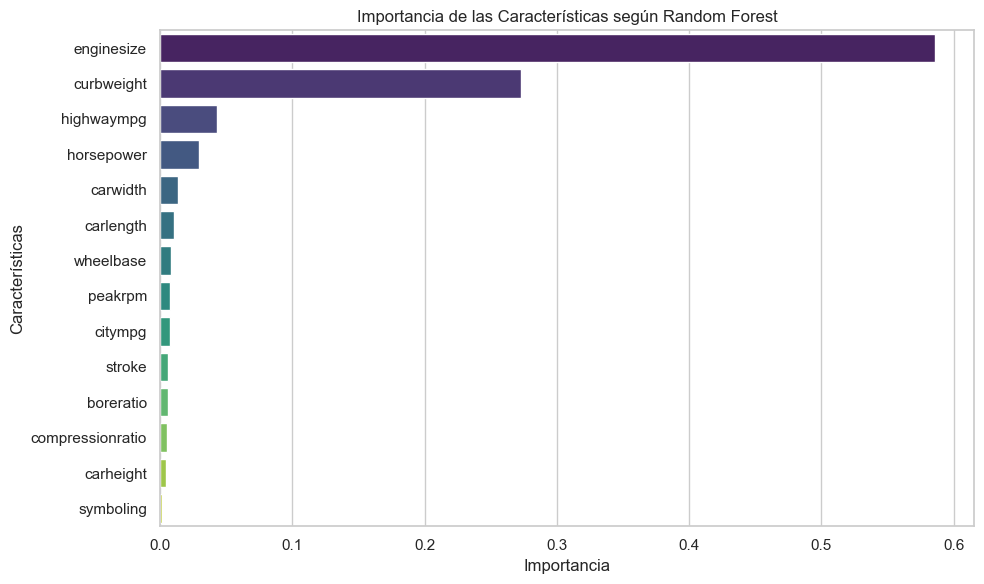

In [369]:
# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Característica', data=importance_df, palette='viridis', hue='Característica', legend=False)

# Añadir etiquetas y título
plt.title('Importancia de las Características según Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Características')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Del gráfico de importancia de características generado por el modelo Random Forest, 'enginesize' y 'curbweight' son las características más importantes para predecir el precio, mientras que 'carwidth' y 'horsepower' tienen una menor importancia relativa, aunque siguen siendo relevantes.

Aunque 'carwidth' tiene una alta correlación con el precio, su importancia en el Random Forest es menor que la de 'enginesize' y 'curbweight'. Esto podría deberse a interacciones no lineales entre las características o redundancia con otras variables.

In [370]:
predicciones = {'Precio real $': y_val, 'Precio predicho $': y_hat, 'Error $': np.abs(y_val-y_hat)}
# Convertir el diccionario en un DataFrame
df_predicciones = pd.DataFrame(predicciones)

In [371]:
df_predicciones

,Precio real $,Precio predicho $,Error $
15,30760.000,36259.262500,5499.262500
9,17859.167,18670.230000,811.063000
100,9549.000,9024.906667,524.093333
132,11850.000,13255.617500,1405.617500
68,28248.000,27913.950000,334.050000
95,7799.000,7321.945000,477.055000
159,7788.000,7914.995000,126.995000
162,9258.000,8028.510000,1229.490000
147,10198.000,10005.554583,192.445417
182,7775.000,8215.240000,440.240000


In [372]:
print(f'El error promedio en validacion: {df_predicciones["Error $"].mean()}$')
print(f'La desviación estandar en el error del precio es de: {df_predicciones["Error $"].std()}$')

El error promedio en validacion: 1205.3733757259001$
La desviación estandar en el error del precio es de: 1324.0911508722543$


## Realizamos selección de caracteristicas

In [373]:
base_model = RandomForestRegressor(n_estimators=200,  # Número de árboles en el bosque
                              max_depth=20,      # Profundidad máxima de los árboles
                              random_state=42,   # Semilla para reproducibilidad
                              n_jobs=-1)         # Utilizar todos los núcleos disponibles

In [374]:
num_features = X_train.shape[1]  # Total de características disponibles
mejor_mse = float('inf')
mejor_num = None
mejores_features = None

In [375]:
for n in range(5, num_features+1):
    rfe = RFE(estimator=base_model, n_features_to_select=n, step=1)  # step=1 elimina de una en una
    rfe.fit(X_train, y_train)
    
    # Transformar los datos
    X_train_selected = rfe.transform(X_train)
    X_val_selected = rfe.transform(X_val)
    
    # Entrenar y evaluar
    final_model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
    final_model.fit(X_train_selected, y_train)
    y_pred = final_model.predict(X_val_selected)
    mse = root_mean_squared_error(y_val, y_pred)
    
    # Verificar si es el mejor resultado
    if mse < mejor_mse:
        mejor_mse = mse
        mejor_num = n
        mejores_features = X_train.columns[rfe.support_]

print(f"Mejor número de características: {mejor_num}")
print(f"RMSE con {mejor_num} características: {mejor_mse}")
print("Características seleccionadas:", mejores_features)

Mejor número de características: 14
RMSE con 14 características: 1778.5895960892335
Características seleccionadas: Index(['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg'],
      dtype='object')


Disminuir el numero de caracteristicas no aumenta el rendimiento del modelo, ya que, obtuvo el menor error utilizando todas las caracteristicas dentro del conjunto de datos.

## **Realizamos un One-hote encoding a las variables categoricas para poder trabajar con ellas y entrenar el algortimo**


In [376]:
# Codificación one-hot para las variables categóricas
x_cat_encoded = pd.get_dummies(x_cat)

In [377]:
# Combinar las variables numéricas con las variables categóricas codificadas
X = pd.concat([x_num, x_cat_encoded], axis=1).drop(columns=['price'])

In [378]:
X.head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,...,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,...,False,False,False,False,False,False,False,True,False,False
1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,...,False,False,False,False,False,False,False,True,False,False
2,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,...,False,False,False,False,False,False,False,True,False,False
3,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,...,False,False,False,False,False,False,False,True,False,False
4,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,...,False,False,False,False,False,False,False,True,False,False


Pasamos de tener 24 caracteristicas a un total de 53 con el one-hote encoding, esto puede causar la maldición de la dimensionalidad

In [379]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [380]:
print(f'Total de caracteristicas: {X_train.shape[-1]}')
print(f'Total de datos de entranmiento: {X_train.shape[0]}')
print(f'Total de datos de validación: {X_val.shape[0]}')

Total de caracteristicas: 52
Total de datos de entranmiento: 164
Total de datos de validación: 41


In [381]:
modelo = RandomForestRegressor(n_estimators=200,
                               max_depth=20, 
                               random_state=42,
                               n_jobs= -1)

In [382]:
modelo.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [383]:
y_hat = modelo.predict(X_val)
#Evaluamos el modelo 
error = root_mean_squared_error(y_val, y_hat)
print(f"Error cuadratico medio del modelo en validacion: {error:.4f}")

Error cuadratico medio del modelo en validacion: 1807.8969


In [384]:
y_pred_train = modelo.predict(X_train)
mse_train = root_mean_squared_error(y_train, y_pred_train)
print(f"MSE en entrenamiento: {mse_train}")

MSE en entrenamiento: 930.6675428806635


Usando las 53 caracteristicas el MSE se reduce de forma sustancial a diferencia de usar solo las 14 caracteristicas númericas iniciales

In [385]:
predicciones = {'Precio real $': y_val, 'Precio predicho $': y_hat, 'Error $': np.abs(y_val-y_hat)}
# Convertir el diccionario en un DataFrame
df_predicciones = pd.DataFrame(predicciones)

In [386]:
df_predicciones

,Precio real $,Precio predicho $,Error $
15,30760.000,35891.547500,5131.547500
9,17859.167,18810.970000,951.803000
100,9549.000,8982.055000,566.945000
132,11850.000,13268.803333,1418.803333
68,28248.000,27815.252500,432.747500
95,7799.000,6499.885000,1299.115000
159,7788.000,7661.390000,126.610000
162,9258.000,8013.280000,1244.720000
147,10198.000,10141.691250,56.308750
182,7775.000,8206.330000,431.330000


## Realicemos selección de caracteristicas intentado mejorar el MSE con menos de 53 caracteristicas

In [387]:
base_model = RandomForestRegressor(n_estimators=200,  # Número de árboles en el bosque
                              max_depth=20,      # Profundidad máxima de los árboles
                              random_state=42,   # Semilla para reproducibilidad
                              n_jobs=-1)         # Utilizar todos los núcleos disponibles

num_features = X_train.shape[1]  # Total de características disponibles
mejor_mse = float('inf')
mejor_num = None
mejores_features = None

In [388]:
for n in range(5, num_features+1):
    rfe = RFE(estimator=base_model, n_features_to_select=n, step=1)  # step=1 elimina de una en una
    rfe.fit(X_train, y_train)
    
    # Transformar los datos
    X_train_selected = rfe.transform(X_train)
    X_val_selected = rfe.transform(X_val)
    
    # Entrenar y evaluar
    final_model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
    final_model.fit(X_train_selected, y_train)
    y_pred = final_model.predict(X_val_selected)
    mse = root_mean_squared_error(y_val, y_pred)
    
    # Verificar si es el mejor resultado
    if mse < mejor_mse:
        mejor_mse = mse
        mejor_num = n
        mejores_features = X_train.columns[rfe.support_]

print(f"Mejor número de características: {mejor_num}")
print(f"RMSE con {mejor_num} características: {mejor_mse}")
print("Características seleccionadas:", mejores_features)

Mejor número de características: 14
RMSE con 14 características: 1778.4660442468091
Características seleccionadas: Index(['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'cylindernumber_four'],
      dtype='object')


El modelo mostró una mejora en el MSE en comparación con el modelo entrenado con las 53 características obtenidas del one-hot encoding. Sin embargo, el MSE sigue siendo igual en relación con el modelo inicial, que utilizó únicamente características numéricas. Es importante destacar que, al aplicar el one-hot encoding, se generaron nuevas características, lo que pudo haber introducido variables más relevantes para el modelo, cambiando así el conjunto final de características utilizadas en el entrenamiento.

## **ENTRENANDO UN MODELO CON REGRESION**

Los modelos re regresión trabajan de mejor forma con datos escalados y distribuciones Gaussianas, por lo cual es necesario realizar un pre procesamiento a los datos para asegurarnos que el modelo tenga un mejor rendimiento.

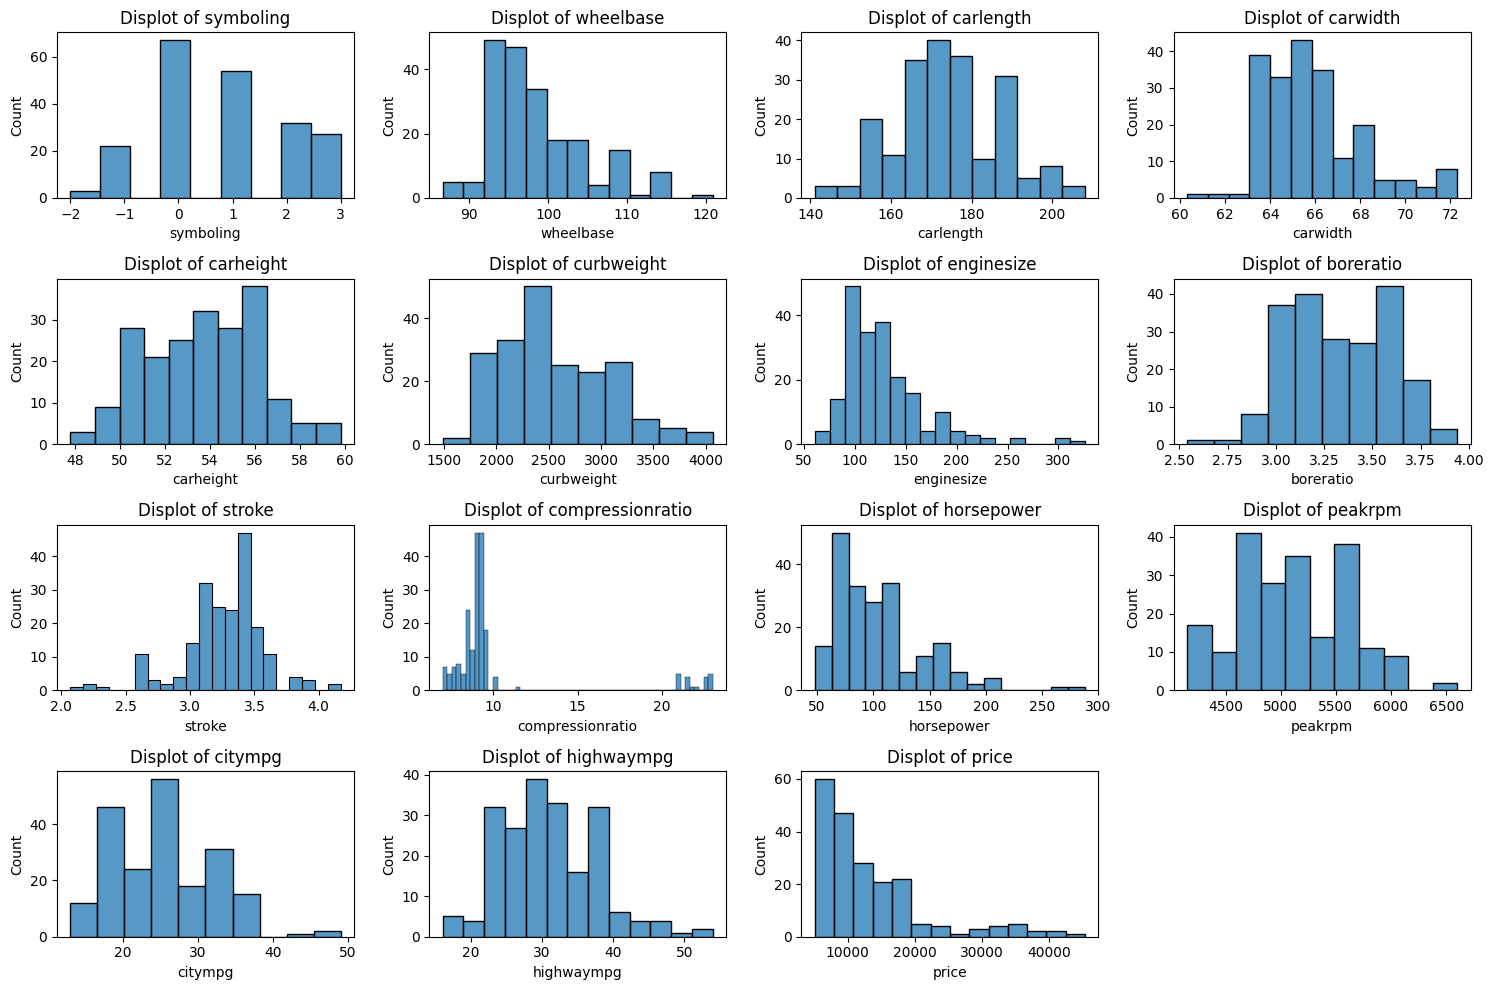

Podemos identificar las características que tienen distribuciones sesgadas o que no parecen seguir una forma normal. Estas características son las que se beneficiarían de una transformación como Yeo-Johnson para aproximar una distribución normal, lo cual es útil para algoritmos como la regresión lineal que asumen normalidad en los datos.

1) enginesize
2) curbweight
3) compressionratio
4) horsepower

In [389]:
df_lr = copy.deepcopy(df) #Creamos una copia del df original para no alteral el df
df_lr = df_lr.drop(columns=['car_ID', 'CarName'], axis=1)

In [390]:
columns_to_transform = ['enginesize', 'curbweight', 'compressionratio', 'horsepower'] #seleccionamos las caracteristicas a transformar 

In [391]:
# Aplicar Yeo-Johnson
pt = PowerTransformer(method='box-cox', standardize=True) #usamos box-cox ya que trabajamos solo con datos positivos 
df_lr[columns_to_transform] = pt.fit_transform(df_lr[columns_to_transform])
# Guardar el transformador
#joblib.dump(pt, 'power_transformer.pkl')

# Cargar el transformador en producción
#pt_loaded = joblib.load('power_transformer.pkl')

In [392]:
# Verificar el valor de lambda (λ)
print("Lambdas calculadas:", pt.lambdas_)

Lambdas calculadas: [-0.9617339  -0.60060071 -3.07010361 -0.6045748 ]


In [393]:
cat_var = (df_lr.dtypes == 'object') 
object_type = list(cat_var[cat_var].index)
num_var = (df_lr.dtypes != 'object') 
num_type = list(num_var[num_var].index)

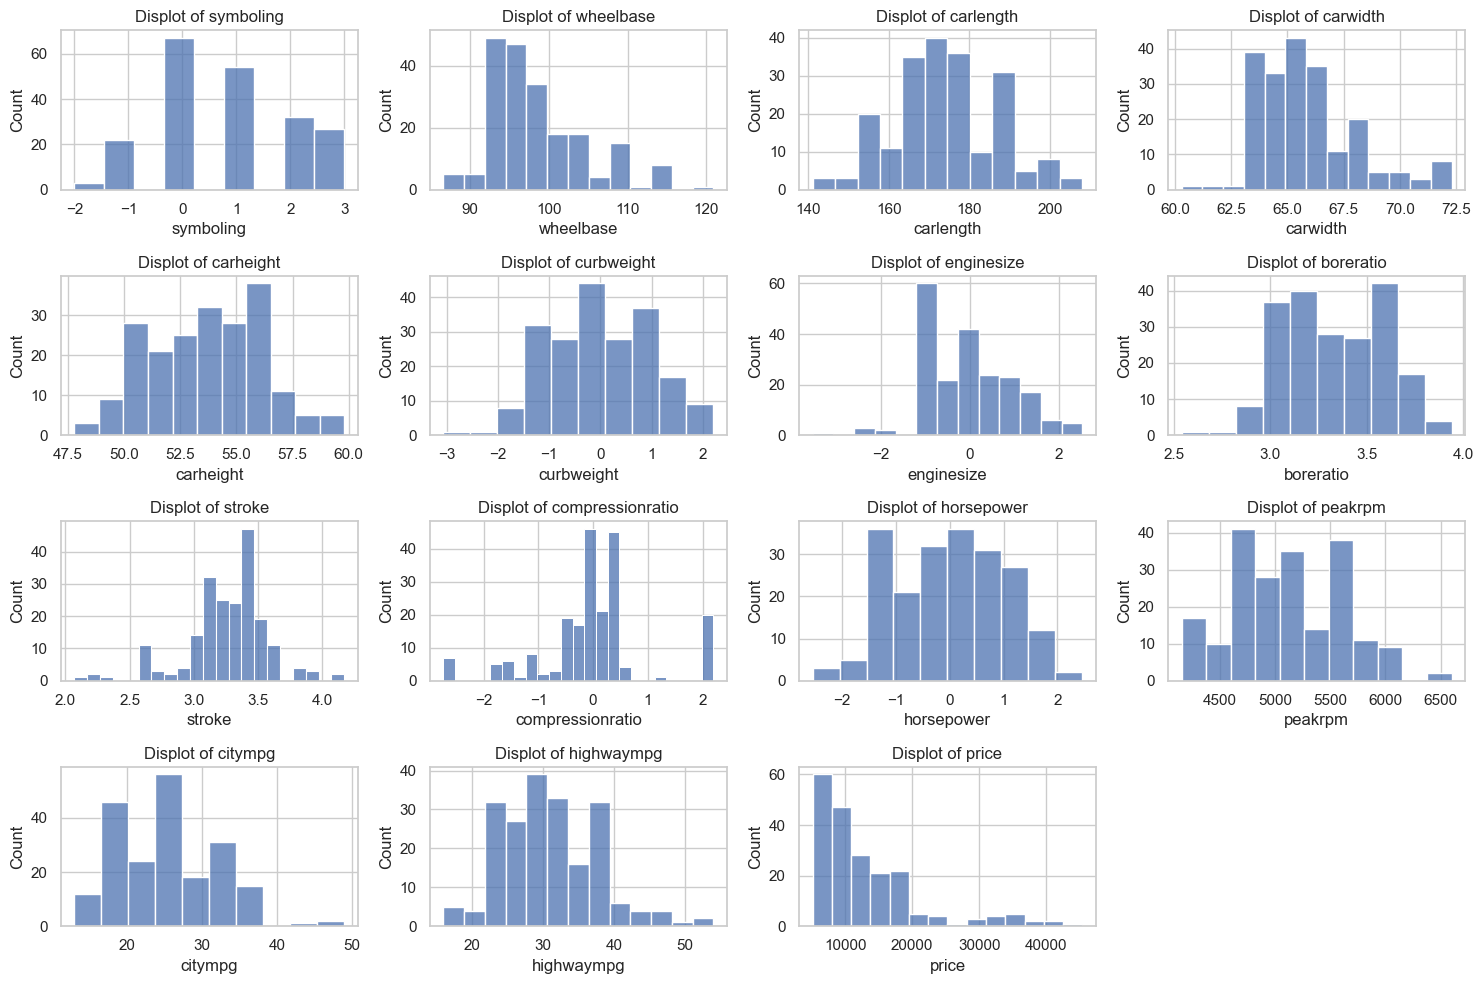

In [394]:
displot_numeric(num_type, df_lr)

## **Entrenamiento con solo las variables numericas**

In [395]:
X = df_lr[num_type].drop(columns=['price'])
y = df_lr['price']

In [396]:
X

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,3,88.6,168.8,64.1,48.8,0.144825,0.380116,3.47,2.68,-0.011717,0.466034,5000,21,27
1,3,88.6,168.8,64.1,48.8,0.144825,0.380116,3.47,2.68,-0.011717,0.466034,5000,21,27
2,1,94.5,171.2,65.5,52.4,0.647094,0.890038,2.68,3.47,-0.011717,1.285797,5000,19,26
3,2,99.8,176.6,66.2,54.3,-0.303496,-0.294328,3.19,3.40,0.635359,0.226616,5500,24,30
4,2,99.4,176.6,66.4,54.3,0.648777,0.535227,3.19,3.40,-1.031703,0.562693,5500,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,109.1,188.8,68.9,55.5,0.856573,0.654588,3.78,3.15,0.346390,0.539039,5400,23,28
201,-1,109.1,188.8,68.8,55.5,1.004677,0.654588,3.78,3.15,-0.268545,1.371340,5300,19,25
202,-1,109.1,188.8,68.9,55.5,0.949085,1.257813,3.58,2.87,-0.178962,0.957214,5500,18,23
203,-1,109.1,188.8,68.9,55.5,1.244120,0.744260,3.01,3.40,2.198311,0.337049,4800,26,27


In [397]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [398]:
#La regrsion polinomicas trabajan mejor con datos escalados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #Aplicar y entrena con base a los datos de entrenamiento

# Guardar el escalador para usarlo en producción
#joblib.dump(scaler, 'scaler.pkl')
X_val_scaled = scaler.transform(X_val) #Aplicamos el transformador a los datos de validacion

In [399]:
# ElasticNet
param_grid_en = {'alpha': [0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.5, 0.9]}
elasticnet = GridSearchCV(ElasticNet(), param_grid_en, scoring='neg_mean_squared_error', cv=5)
elasticnet.fit(X_train_scaled, y_train)
print("Mejor combinación para ElasticNet:", elasticnet.best_params_)
print("MSE para ElasticNet:", root_mean_squared_error(y_val, elasticnet.best_estimator_.predict(X_val_scaled)))

Mejor combinación para ElasticNet: {'alpha': 1, 'l1_ratio': 0.9}
MSE para ElasticNet: 5332.64592692089


In [400]:
#Usando diferentes grados de polinomio
# Crear un pipeline con PolynomialFeatures y Ridge
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Genera características polinómicas
    ('ridge', Ridge())               # Modelo con regularización L2
])

# Definir el rango de hiperparámetros
param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],  # Grados polinómicos
    'ridge__alpha': [0.01, 0.1, 1, 10, 100]  # Fuerza de regularización
}

In [402]:
# Configurar GridSearchCV
grid = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5)
grid.fit(X_train_scaled, y_train)

# Mejor modelo encontrado
best_model = grid.best_estimator_
print("Mejores parámetros:", grid.best_params_)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_val_scaled)
print("RMSE en el conjunto de prueba:", root_mean_squared_error(y_val, y_pred))

Mejores parámetros: {'poly__degree': 2, 'ridge__alpha': 10}
RMSE en el conjunto de prueba: 4296.047896374483


In [403]:
# Extraer los mejores hiperparámetros
best_degree = grid.best_params_['poly__degree']
best_alpha = grid.best_params_['ridge__alpha']

In [404]:
# Crear y ajustar el modelo con los mejores hiperparámetros
final_model = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree)),  # Características polinómicas
    ('ridge', Ridge(alpha=best_alpha))  # Modelo Ridge con regularización óptima
])

# Entrenar el modelo
final_model.fit(X_train_scaled, y_train)

# Evaluar en el conjunto de validación
y_pred = final_model.predict(X_val_scaled)
print("RMSE en el conjunto de validación:", root_mean_squared_error(y_val, y_pred))

RMSE en el conjunto de validación: 4296.047896374483


## **Selección de caracteristicas**

In [405]:
# Crear características polinómicas
poly = PolynomialFeatures(degree=2)  #Mejor grado encontrado
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)

In [406]:
base_model = Ridge(alpha=10.0)  # Ridge con regularización (mejor valor junto con polinomio de grado 2)

In [408]:
# Variables para guardar los mejores resultados
num_features = X_train_poly.shape[1]  # Total de características generadas por PolynomialFeatures
mejor_mse = float('inf')
mejor_num = None
mejores_features = None

# Iterar sobre diferentes números de características
for n in range(5, num_features + 1):
    # Aplicar RFE
    rfe = RFE(estimator=base_model, n_features_to_select=n, step=1)  # step=1 elimina de una en una
    rfe.fit(X_train_poly, y_train)
    
    # Transformar los datos con las características seleccionadas
    X_train_selected = rfe.transform(X_train_poly)
    X_val_selected = rfe.transform(X_val_poly)
    
    # Entrenar y evaluar el modelo
    final_model = Ridge(alpha=10.0)
    final_model.fit(X_train_selected, y_train)
    y_pred = final_model.predict(X_val_selected)
    mse = root_mean_squared_error(y_val, y_pred)
    
    # Verificar si este modelo es el mejor
    if mse < mejor_mse:
        mejor_mse = mse
        mejor_num = n
        mejores_features = rfe.support_  # Guardar las características seleccionadas

# Obtener los nombres de las características seleccionadas
feature_names = poly.get_feature_names_out(input_features=X_train.columns)
selected_features = [feature_names[i] for i in range(len(feature_names)) if mejores_features[i]]

# Imprimir los resultados
print(f"Mejor número de características: {mejor_num}")
print(f"RMSE con {mejor_num} características: {mejor_mse}$")
print("Características seleccionadas:", selected_features)

Mejor número de características: 10
RMSE con 10 características: 3683.189119514304$
Características seleccionadas: ['curbweight', 'enginesize', 'horsepower', 'citympg', 'carwidth stroke', 'carwidth highwaympg', 'curbweight peakrpm', 'enginesize boreratio', 'boreratio peakrpm', 'stroke citympg']
